# Description of the model

The model from Saiz et al has three parts in the model

## Mechanics

The cells are spheroids that behave under the following equations:

$$
m_i\frac{dv_i}{dt} =-bv_i+\sum_j F_{ij}
$$
$$
\frac{dx_i}{dt} =v_i
$$

where the force is

$$
F_{ij}=
\begin{cases}
F_0(\frac{r_{ij}}{d_{ij}}-1)(\frac{\mu r_{ij}}{d_{ij}}-1)\frac{(x_i-x_j)}{d_{ij}}\hspace{1cm}if\;d_{ij}<\mu r_{ij}\\
0\hspace{5cm}otherwise
\end{cases}
$$

where $d_{ij}$ is the Euclidean distance and $r_{ij}$ is the sum of both radius.

## Biochemical interaction

Each cell has a biochemical component that follows an equation of the form:

$$
\frac{dx_i}{dt}=\frac{α(1+x^n_i)^m}{(1+x^n_i)^m+(1+(\langle x\rangle_i)/K)^{2m}}-x_i
$$

This is similar to the above case. The only detail required is to note that the average expression can be modeled as the combination of two interacting variables. The biochemical system is activated in the interval $[t_{on},t_{off}]$.

We made explicit that the average operator can be written as two interaction parameters that are the contraction along the second index that runs over the neighbours of each cell as,

$$
N_{ij}=
\begin{cases}
1\hspace{1cm}d<f_{range}r_{ij}\\
0\hspace{1cm}otherwise
\end{cases}
$$

$$
X_{ij}=
\begin{cases}
x_j\hspace{1cm}d<f_{range}r_{ij}\\
0\hspace{1cm}otherwise
\end{cases}
$$

$$
\langle x\rangle_i=\frac{\sum_j X_{ij}}{\sum_j N_{ij}}=\frac{X_{i}}{N_{i}}
$$

## Growth

The cells present division. The rules for the division in this model are. Random election of a division direction over the unit sphere. The daughter cells divide equally in mass and volume and are positioned in oposite directions around the division axis centered at the parent cell. The chemical concentration is divided asymmetrically with each cell taking $1\pm\sigma_x \text{Uniform}(0,1)$ for the parent cell. A new division time is assigned to each aghter cell from a uniform distribution $\text{Uniform}(\tau_{div}(1-\sigma_{div}),\tau_{div}(1+\sigma_{div}))$.

# Implementation of the model

In [1]:
using AgentBasedModels
abm = AgentBasedModels

using Random
using Distributions
using CUDA

using GLMakie
using ProgressMeter

using CSV
using DataFrames

include("./CustomFunctionsDevelopment.jl");

## Create the model

### Define the agent

First, we have to create an instance of an agent with all the propoerties of the agents.First, we have to create an instance of an agent with all the propoerties of the agents.

In [2]:
m = @agent(3,
    
    #Global parameters
    [α,K,nn,mm,fRange,mi,ri,b,k0,fAdh,μ,τDiv,σDiv,c0,σc,nCirc,σNCirc,fMin,fMax,fPrE,fEPI,τCirc,στCirc,rESC]::Global,
    
    #Local parameters mechanics
    [vx,vy,vz]::Local,                  #Velocities
    [Fix,Fiy,Fiz]::LocalInteraction,    #Interaction forces
    [m,r]::Local,                       #Mass and radius of the model
    Ftheta::GlobalArray,                #Matrix of interaction forces
    
    #Local parameters biochemistry
    [nOn,cMax]::Global,                 #Global parameter setting the start of the biochemistry, maximum concentration of the model to decide fate commitment
    c::Local,                           #Biochemical component
    [ci,ni]::LocalInteraction,          #Neighbors concentration and number of neighbors to make average neighbor expression
    tOff::Identity,                     #indicate if the circuit for that cell is on or off
    cellId::Identity,                   #Identity of the cell (1 DP, 2 EPI, 3 PRE)

    #Local parameters for growth
    tDivision::Local,                   #Variable storing the time of division of the cell

    #Mechanics
    
    UpdateVariable = begin
        d(vx) = (-b*vx/m+Fix/m)*dt
        d(vy) = (-b*vy/m+Fiy/m)*dt
        d(vz) = (-b*vz/m+Fiz/m)*dt
        d(x) = vx*dt
        d(y) = vy*dt
        d(z) = vz*dt
    end,
    
    UpdateInteraction = begin
        dij = sqrt((x.i-x.j)^2+(y.i-y.j)^2+(z.i-z.j)^2)
        rij = r.i+r.j
        if dij < μ*rij && dij > 0
            Fix.i += Ftheta[cellId.i,cellId.j]*(rij/dij-1)*(μ*rij/dij-1)*(x.i-x.j)/dij
            Fiy.i += Ftheta[cellId.i,cellId.j]*(rij/dij-1)*(μ*rij/dij-1)*(y.i-y.j)/dij
            Fiz.i += Ftheta[cellId.i,cellId.j]*(rij/dij-1)*(μ*rij/dij-1)*(z.i-z.j)/dij   
        end
    end,
    
    #Biochemistry
        
    UpdateVariable = begin
        if tOff == 0 && N > nOn
            d(c) = (α*(1+c^nn)^mm/((1+c^nn)^mm+(1+(ci/ni)/K)^(2*mm))-c)*dt
        else
            d(c) = 0*dt
        end
    end,
        
    UpdateInteraction= begin
        if dij < fRange*rij #Unnecessary to compute dij and rij again, previously computed in UpdateInteraction
            ni.i += 1
            ci.i += c.j
        end 
    end,
    
    UpdateLocal=begin
        if c < fPrE*cMax && tOff == 0 && N > nOn
            cellId = 3
            tOff = 1
        elseif c > fEPI*cMax && tOff == 0 && N > nOn
            cellId = 2
            tOff = 1
        end
    end,
    
    #Growth

    UpdateLocal = begin
                
        if t > tDivision
            #Choose random direction in unit sphere
            xₐ = Normal(0,1); yₐ = Normal(0,1); zₐ = Normal(0,1)
            Tₐ = sqrt(xₐ^2+yₐ^2+zₐ^2)
            xₐ /= Tₐ;yₐ /= Tₐ;zₐ /= Tₐ    

            #Chose a random distribution of the material
            dist = Uniform(1-σc,1+σc)

            rsep = r/2
            rnew = r/(2. ^(1. /3))
            
            addAgent( #Add new agent
                x = x+rsep*xₐ,
                y = y+rsep*yₐ,
                z = z+rsep*zₐ,
                vx = 0,
                vy = 0,
                vz = 0,
                r = rnew,
                m = m/2,
                c = c*(dist),
                tDivision = tDivision + Uniform(τDiv*(1-σDiv),τDiv*(1+σDiv)),
                tOff = tOff,
                cellId = cellId
            )
            addAgent( #Add new agent
                x = x-rsep*xₐ,
                y = y-rsep*yₐ,
                z = z-rsep*zₐ,
                vx = 0,
                vy = 0,
                vz = 0,
                r = rnew,
                m = m/2,
                c = c*(2-dist),
                tDivision = tDivision + Uniform(τDiv*(1-σDiv),τDiv*(1+σDiv)),
                tOff = tOff,
                cellId = cellId
            )
            
            removeAgent() # Remove agent that divided
            
        end
    end,
);

### Compile the model

Once created the group, we compile the code to construct the evolution function of the model. 

The parameters we choose:

 - **platform="cpu"**: The model has very low number of agents so a CPU will be the fastest environment. 
 - **neighbors="full**: For the same reason as above, the neighborhood algorithm "full" that computes all the pairs of interactions between all the agents is a good choice.
 - **save="RAM"**: The data is very small and we are going to work online.
 - **integrator="Euler"**: We choose the simplest integrator possible as it turns out to be fine for the work at hand.

In [3]:
mCompiled = compile(m,platform="cpu",neighbors="full",save="RAM",integrator="Euler");

## Create a initial Community

Once with the model created, we have to construct an initial Community of agents to evolve.

### Parameters

The model from the original version has some parameters defined. We create a dictionary with all the parameters from the model assigned.

In [4]:
parameters = Dict([
:α => 10,
:K => .9,
:nn => 2,
:mm => 2,
:fRange => 1.2,
:mi => 10E-6,
:ri => 5,
:b => 10E-6,
:k0 => 10E-4,
:fAdh => 1.5,
:μ => 2,
:τDiv => 10,
:σDiv => .5,
:c0 => 3,
:σc => 0.01,
:nCirc => 20,
:σNCirc => .1,
:fMin => .05,
:fMax => .95,
:fPrE => .2,
:fEPI => .8,
:τCirc => 45.,
:στCirc => .02,
:rESC => 2
]);

### Initialise the community

The model starts from just one agent. Create the community and assign all the parameters to the Community object.

In [5]:
com = Community(mCompiled,N=1)

#Global parameters
setParameters!(com,parameters)

#Global array
com.Ftheta = com.k0 ./ com.fAdh .* ones(3,3) #Start with reduced adhesion
for i in 1:3 #Increase adhesion in the diagonal
    com.Ftheta[i,i] = com.k0
end
com.nOn = rand(Uniform(com.nCirc-com.σNCirc,com.nCirc+com.σNCirc))
com.cMax = com.α/(1+1/(2*com.K)^(2*com.mm))

#########Local parameters and variables###########
#Initialise locals
com.m .= com.mi
com.r .= com.ri
com.cellId .= 1 #Start neutral fate
com.tOff .= 0 #Start with the tOff deactivated
#Initialise variables
com.x .= 0.
com.y .= 0.
com.z .= 0.
com.vx .= 0.
com.vy .= 0.
com.vz .= 0.
com.c .= com.c0
com.tDivision .= 1#rand(Uniform(com.τDiv-com.σDiv,com.τDiv+com.σDiv))

#Simulation grid parameters
com.simulationBox .= [-10 10;-10 10;-10 10]
com.radiusInteraction = 10;

## Evolve the community

We are ready to evolve the system.

 - **dt=0.0002** (Compulsory parameter) We choose this step size as is the biggest size that is stable for theevolution.
 - **tMax=100** (Compulsory parameter) We choose this parameter to be large enough as to have communities of the chosen size.
 - **nStop=40** This parameter as we want to stop the simulation when the Community has reached a maximum size that is consistent with the size of the real data.
 - **nMax=100** Maximum number of agents that the community will have.
 - **dtSave=1** Step size at which save an instance of the Community.

In [6]:
comt = mCompiled.evolve(com,dt=0.0002,tMax=100,nStop=40,nMax=100,dtSave=1);

### Visualization of results

We check how the agents starts to divide and choose a fate at late stages of the simulation.

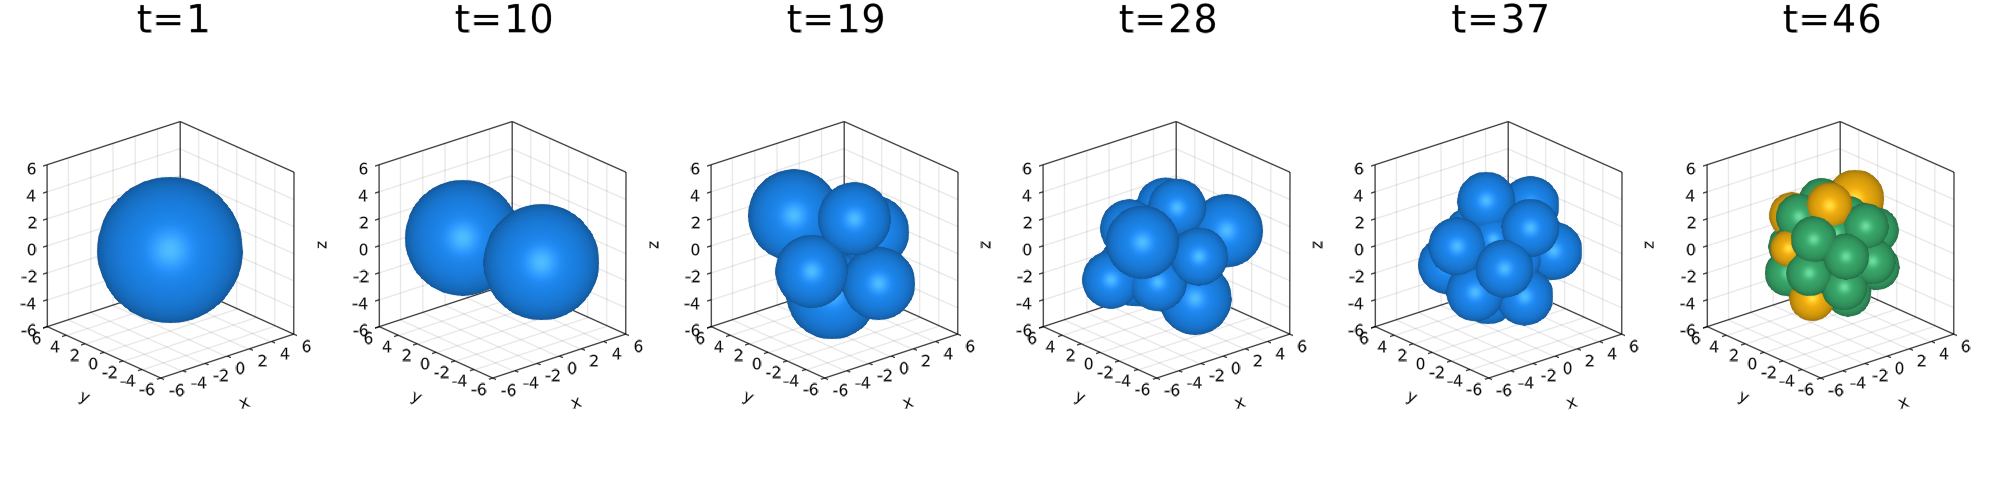

In [7]:
fig = Figure(resolution=(2000,500))

CustomFunction.plotCells(comt,fig)

fig

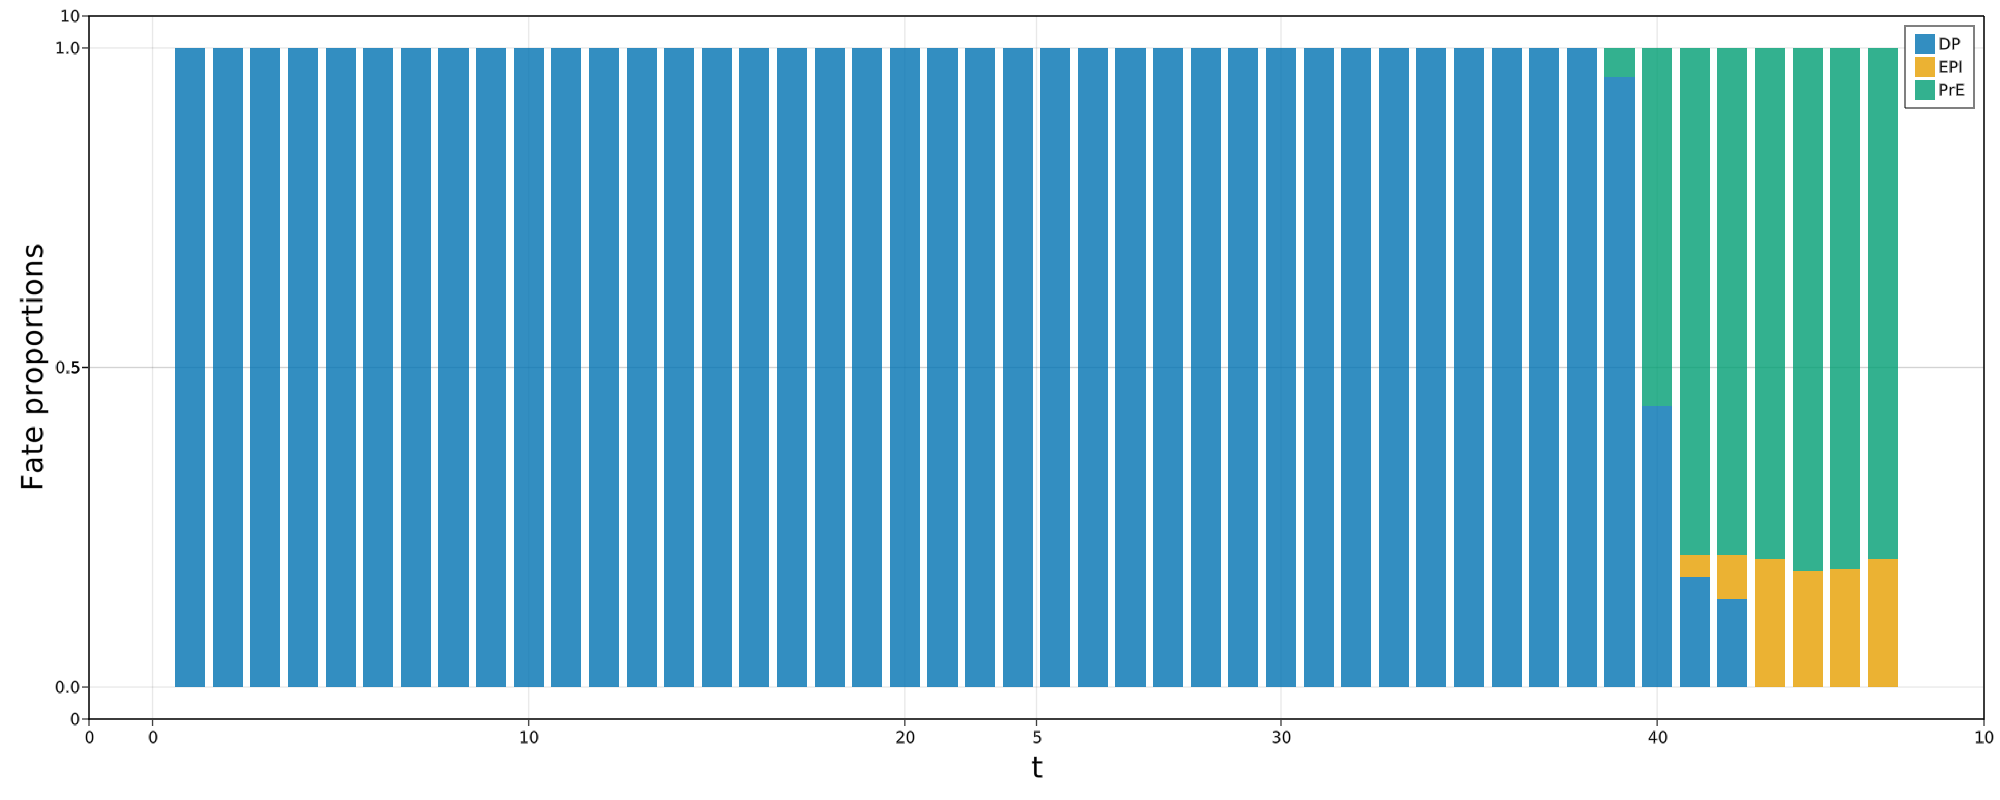

In [8]:
fig = Figure(resolution=(2000,800))

ax = Axis(fig[1,1])

CustomFunction.plotFatesTime(comt,fig,1,1,normalize=true)

fig

## Make statistics of the model

This model contains stochasticity in the division times and the concentration of chemical concentrations that the daughter agents receive. This will make different runs of the simulation to differ. In order to make statistics we run the model several times and collect the information of the size and fates of the cells.

### Evolution of proportions

the function `CustomFunction.batchSimulationsCustomFunction.batchSimulations` is a simply function that wraps up the construction of a community and its evolution over several itterations and takes the relevant information of the agent of our interest and returns it in a DataFrame object.

In [9]:
simulatedData = CustomFunction.batchSimulations(mCompiled,parameters);

### Visualize results

We now have the statistics of the model and we can visualize the proportion of cell types during time and total size.

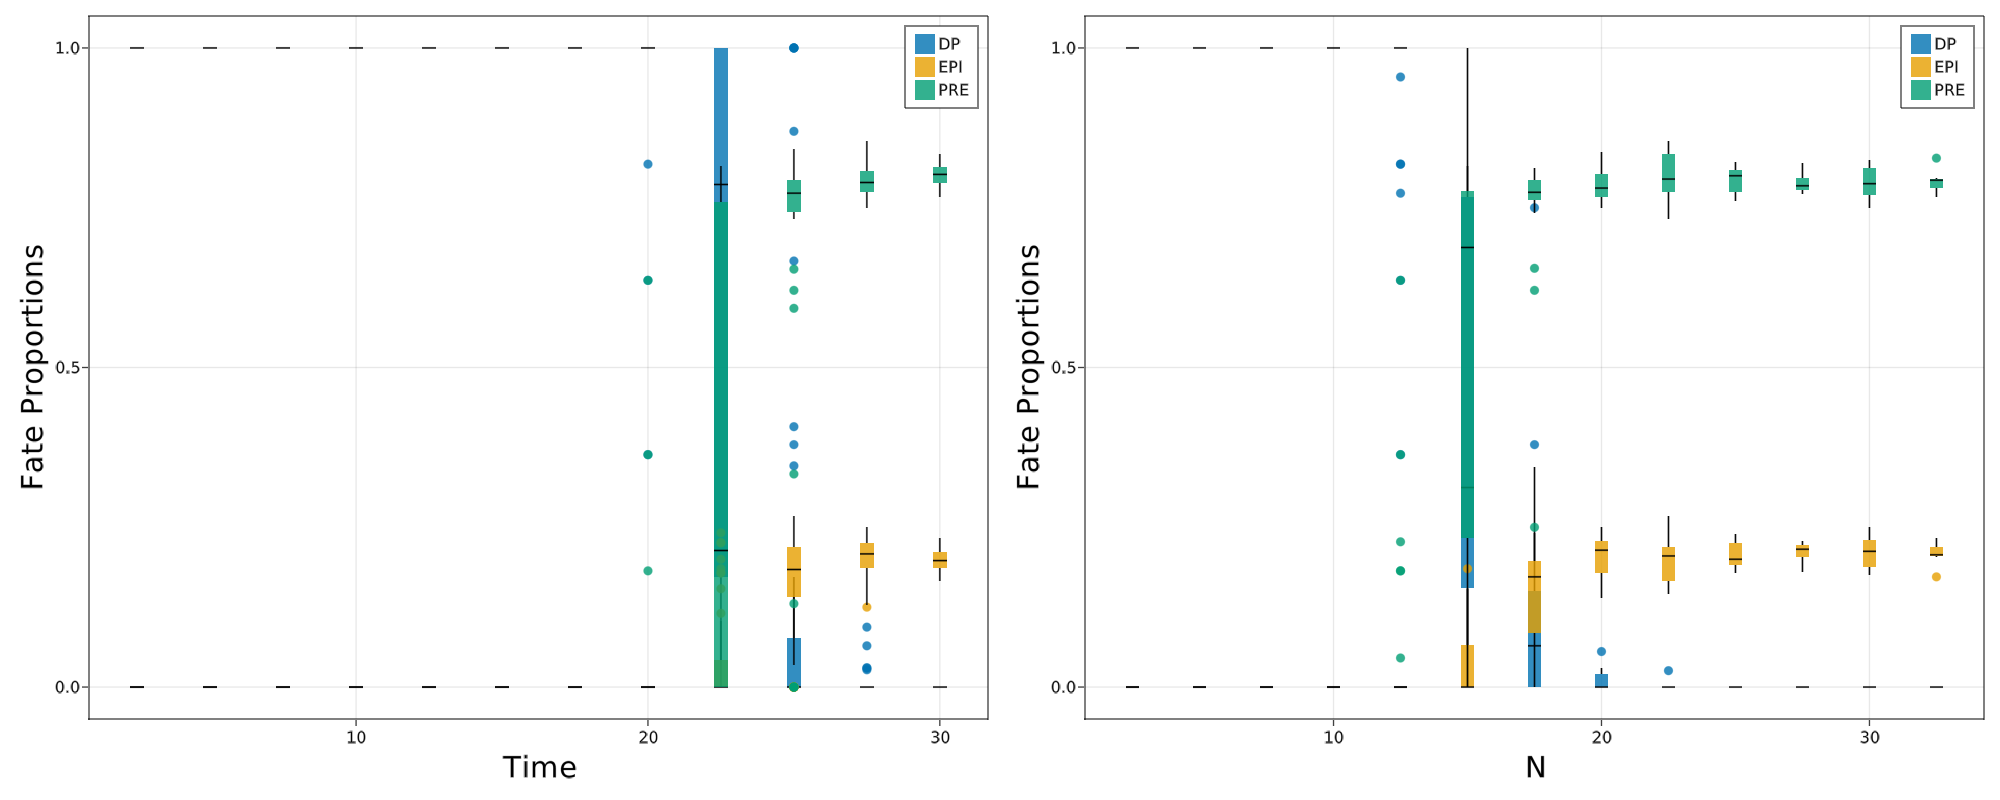

In [10]:
fig = Figure(resolution=(2000,800))

CustomFunction.plotProportions(simulatedData,5,fig,1,1)
CustomFunction.plotProportions(simulatedData,5,fig,1,2,flavor=:N)

fig

# Fitting the model

The parameters above described were chosen to match the experimental observation. This was a qualitative fitting where the parameters where tuned by hand.

In this section we will show how we can use tuning functions to choose optimize certain parameters of the model. In particular, we tune the model to fit parameters related with the chemical circuit to match the correct distributions of cells.

## Upload experimental data

We upload the experimental data that gives raise to this model.

In [11]:
data = CustomFunction.uploadExperimentalData();

### Visualize data

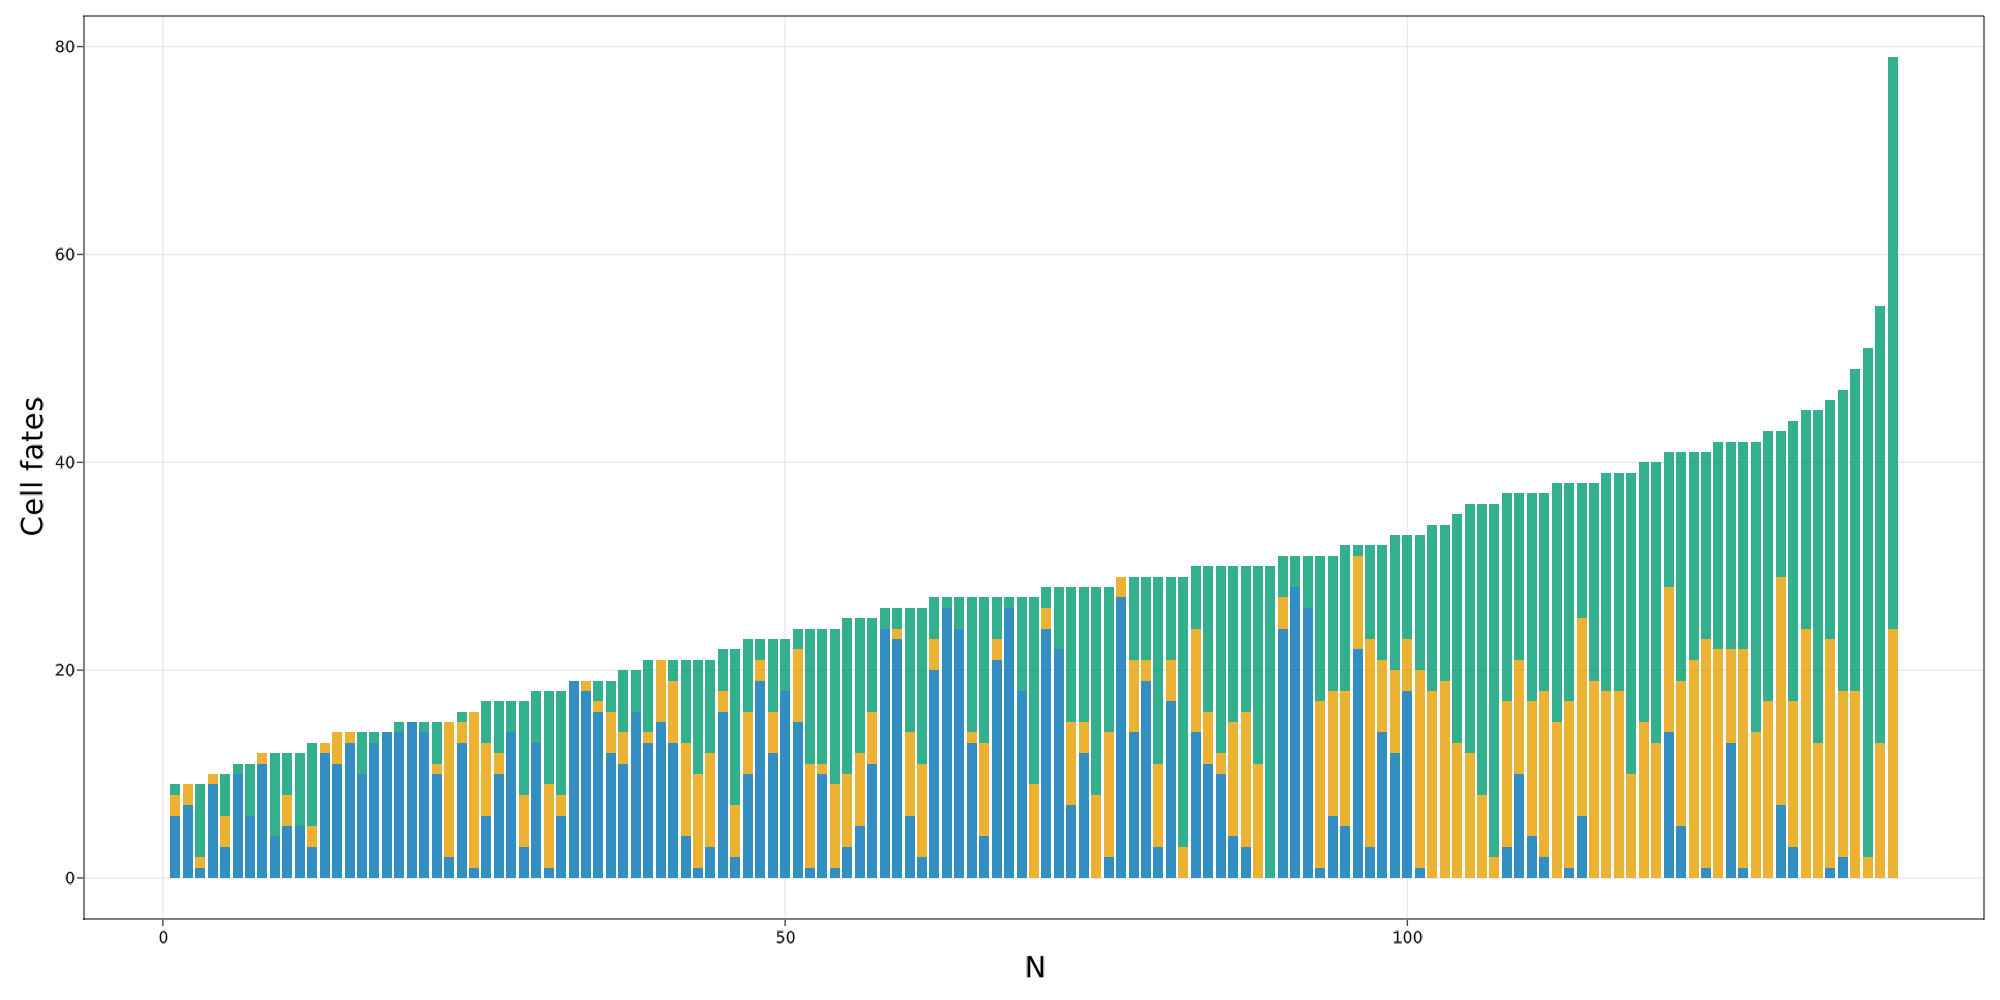

In [12]:
fig = Figure(resolution=(2000,1000))

ax = Axis(fig[1,1],xlabel="N",xlabelsize=30,ylabel="Cell fates",ylabelsize=30)

offset = zeros(size(data)[1])
legend = []
for cellId in ["DP","EPI","PRE"]
    bp = barplot!(ax,data[!,cellId], offset=offset)
    push!(legend,bp)
    offset .+= data[!,cellId]
end

fig

We see that the data corresponds to sets ranging from 5 to 60 cells, being the usual sized between 5 to 30. 

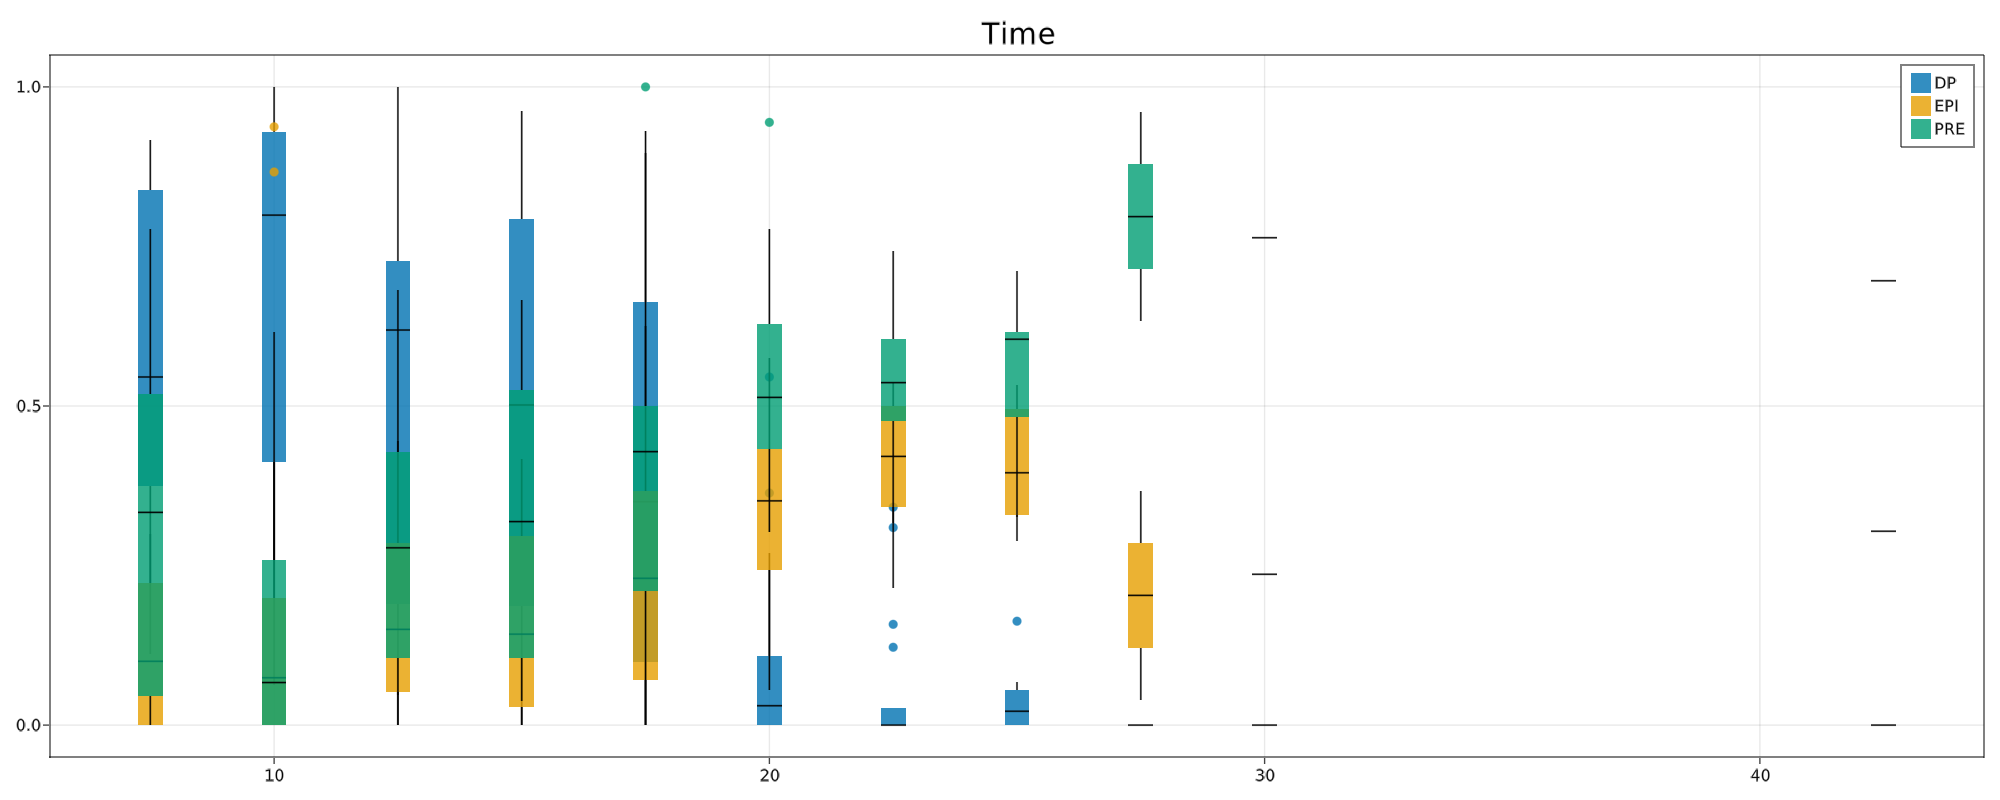

In [13]:
fig = Figure(resolution=(2000,800))

cluster = 5
CustomFunction.plotData(data,cluster,fig,1,1)

fig

### Prepare experimental data for fitting

To increase the statistical power, we cluster the data into bins of total cell number and compute the mean and variance statistics.

In [14]:
dataFit = CustomFunction.clusterExperimentalData(data)

,NCluster,PropDPMean,PropEpiMean,PropPreMean,PropDPVar,PropEpiVar,PropPreVar
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,7.5,0.57213,0.117172,0.310698,0.0783641,0.0129534,0.0826128
2,10.0,0.666324,0.185325,0.148351,0.106707,0.0813161,0.0356754
3,12.5,0.531393,0.190841,0.277767,0.103513,0.0274729,0.0444675
4,15.0,0.508135,0.164428,0.327437,0.111539,0.0209876,0.0471392
5,17.5,0.381015,0.226418,0.392567,0.102499,0.0299968,0.0612153
6,20.0,0.111762,0.346149,0.542089,0.03021,0.0243066,0.0308021
7,22.5,0.0591382,0.411671,0.529191,0.0121628,0.00968479,0.0125616
8,25.0,0.0421807,0.409438,0.548381,0.00349641,0.00972507,0.0162125
9,27.5,0.0,0.203281,0.796719,1.0,0.0538351,0.0538351


## Note on simulated data

We cluster the data in the same way so we can compare the experiments and simulations. Notice that the simulations have statistics at all sizes. We will have to limit to the experimental range in order to compare them.

In [15]:
dataExperimentalFit = CustomFunction.clusterSimulatedData(simulatedData)

,NCluster,PropDPMean,PropEpiMean,PropPreMean,PropDPVar,PropEpiVar,PropPreVar
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2.5,1.0,0.0,0.0,0.0,0.0,0.0
2,5.0,1.0,0.0,0.0,0.0,0.0,0.0
3,7.5,1.0,0.0,0.0,0.0,0.0,0.0
4,10.0,1.0,0.0,0.0,0.0,0.0,0.0
5,12.5,0.958042,0.0,0.041958,0.0154833,0.0,0.0154833
6,15.0,0.433957,0.0399762,0.526067,0.125634,0.0037344,0.0999143
7,17.5,0.106723,0.143919,0.749358,0.0264177,0.00596286,0.0117087
8,20.0,0.00958891,0.205069,0.785342,0.000286084,0.00118204,0.000720346
9,22.5,0.00134953,0.200886,0.797764,3.46033e-5,0.00137099,0.00141768


## Set the exploration space

The optimization algorithms require that you specify a set of parameters to optimize. in our case, our parameters correspond to parameters to the agent. However, they does not need to correcpond to parameters of the agent at all. They will be specified for the algorithm to sample from them and give new updates while optimising. 

We have to define them as a dicctionary.

In [16]:
explore = Dict([
            :α=>(0,20),
            :K=>(0,2),
            :nn=>(0,5),
            :mm=>(0,5)
        ]);

## Construct loos function

With the data prepared to be compared, we set the loos function. 

The loos function is a function that has to receive at least one argument, a `RowDataframe` object that contains the information of the parameters that are being fitted and has to return a value indicating how good wwere the simulations.

The function is very general so it can fit a many different routines.

Our function basically contains the following steps:

 - Sets the new parameters
 - Run several simulations for that set of parameters to get robust statistics
 - Cluster the results from the simulations as before to compare it to the experimental data
 - Compare the experimental and simulation results using a Chi Square metric as loos value.
 
The specific form of the function will depend on the optimization algorithm at hand.

In [17]:
function loosFunction(params,parameters,dataFit,nRepetitions=10)

    #Modify the set of parameters
    parametersModified = copy(parameters)
    parametersModified[:α] = params.α[1]
    parametersModified[:K] = params.K[1]
    parametersModified[:nn] = params.nn[1]
    parametersModified[:mm] = params.mm[1]
    
    #Make a batch of simulations and get relevant information
    simulatedData = CustomFunction.batchSimulations(mCompiled, parametersModified, nRepetitions)

    #Prepare data for fitting
    simulatedFit = CustomFunction.clusterSimulatedData(simulatedData,5)[3:2+size(dataFit)[1],:]
    
    #Xi square loos
    loos = sum((simulatedFit.PropDPMean .- dataFit.PropDPMean).^2 ./dataFit.PropDPVar .+
    (simulatedFit.PropEpiMean .- dataFit.PropEpiMean).^2 ./dataFit.PropEpiVar .+
    (simulatedFit.PropPreMean .- dataFit.PropPreMean).^2 ./dataFit.PropPreVar)
    
    #Return loos
    return loos
    
end

loosFunction (generic function with 2 methods)

### Check stability of loos function

We run the loos function several times to check that the results are consistent between runs. If the loos function returned different results outside the expected fluctuations, the model would not be proporly fitted as the algorithms would not be able to minimize consistently the cost.

The fluctuations for the simulations using 10 repetitions of the simulation for the same parameters show already enough consistency.

In [18]:
initialisation = DataFrame([:α=>parameters[:α],:K=>parameters[:K],:nn=>parameters[:nn],:mm=>parameters[:mm]])

Threads.@threads for i in 1:6
    println(loosFunction(initialisation,parameters,dataFit,10))
end

37.524702069795865
35.692004150800024
39.58578228237162
38.01336764695495
36.61591815064281
38.63926523924343


## Run the optimization algorithm

Once we have set the loos function and the parameter space to be explored, we can run the algorithm.

The algorithm has done a good job finding a fet of parameters that fits the data. Moreover, it fits better the data than the qualitative fitting that seems to want ot match only the final proportions at step 30.

The discrepacy at earlier time comes from the fact that the chemical circuit only starts at a critial size of `N=20`. A further improvement on the optimization would be to change this global parameter i the system or even to add it to the fitting process.

Overall, we showed the capacity of AgentBasedModels to fit models to real data.

In [19]:
AgentBasedModels.Optimization.swarmAlgorithm(loosFunction,
                                        explore,
                                        population=50,
                                        stopMaxGenerations=10,
                                        saveFileName="OptimizationResults",
                                        args=[parameters,dataFit,10]
                                    )

Generation 1/10 100%|████████████████████████████████████| Time: 0:04:20
Generation 2/10 100%|████████████████████████████████████| Time: 0:04:19
Generation 3/10 100%|████████████████████████████████████| Time: 0:04:19
Generation 4/10 100%|████████████████████████████████████| Time: 0:04:23
Generation 5/10 100%|████████████████████████████████████| Time: 0:04:16
Generation 6/10 100%|████████████████████████████████████| Time: 0:04:12
Generation 7/10 100%|████████████████████████████████████| Time: 0:04:11
Generation 8/10 100%|████████████████████████████████████| Time: 0:04:12
Generation 9/10 100%|████████████████████████████████████| Time: 0:04:11
Generation 10/10 100%|███████████████████████████████████| Time: 0:04:13


,α,nn,K,mm,α_velocity_,nn_velocity_,K_velocity_,mm_velocity_
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
456,10.0549,1.92812,1.16596,1.85842,0.447707,0.053659,-0.0858023,0.00522784


### Visualize results

Clearly the algorithm tends to converge to better solutions over time.

A plot of the best solution 

In [27]:
optimization = CSV.read("OptimizationResults.csv",DataFrame);

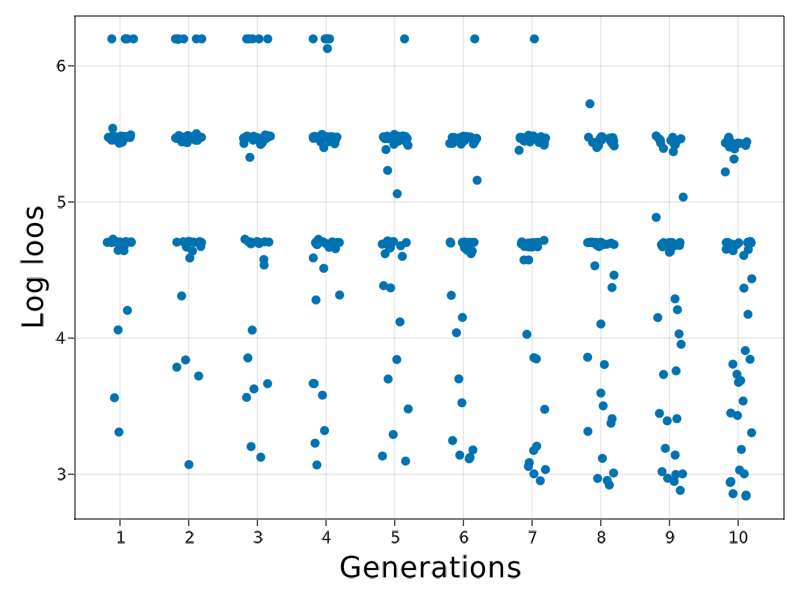

In [76]:
fig = Figure()
ax = Axis(fig[1,1],xticks=1:10,xlabel="Generations",xlabelsize=30,ylabel="Log loos",ylabelsize=30)

scatter!(ax,optimization._generation_.+rand(Uniform(-.2,.2),500),log.(optimization._score_))
#xticks!(ax,[1,2,3],[1,2,3])

fig

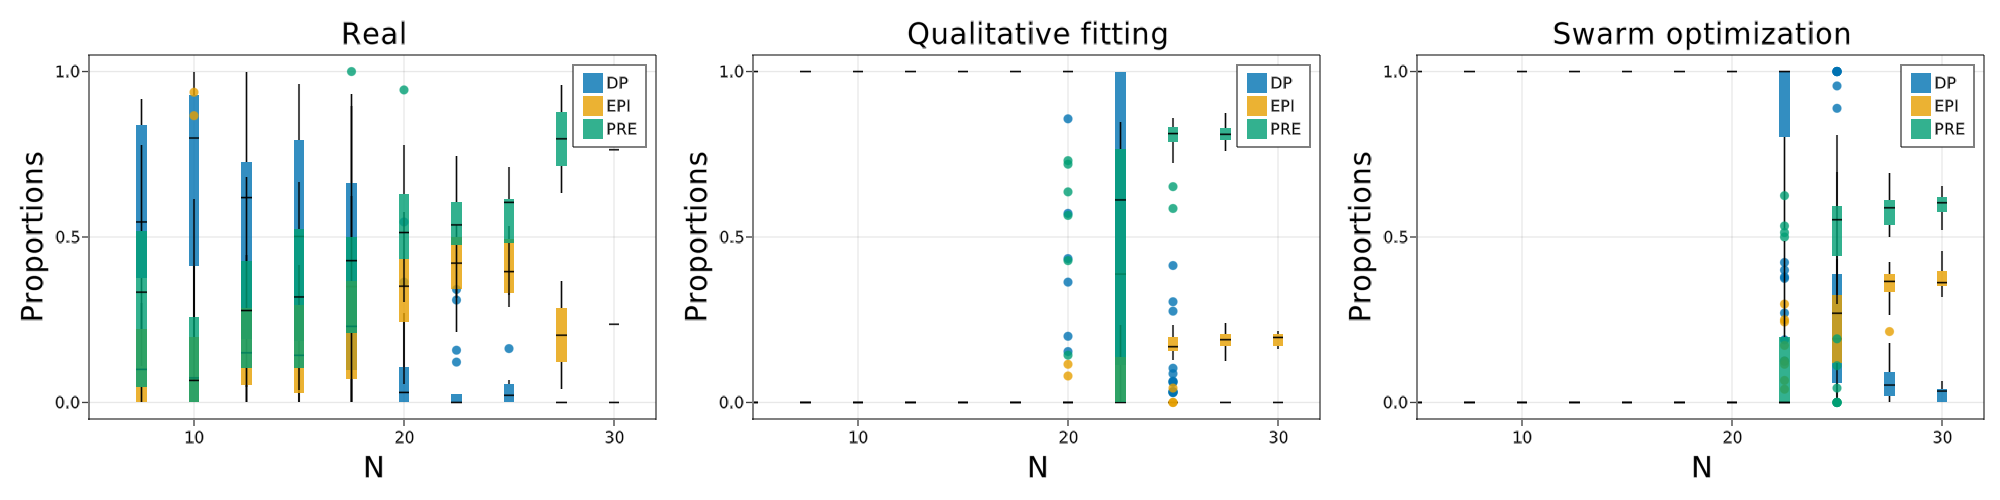

In [107]:
fig = Figure(resolution=(2000,500))

cluster = 5
ax = CustomFunction.plotData(data[1:end,:],cluster,fig,1,1)
ax.title="Real"; ax.titlesize = 30;
ax.xlabel="N"; ax.xlabelsize = 30;
ax.ylabel="Proportions"; ax.ylabelsize = 30;
xlims!(ax,5,32)

cluster = 5
#simulatedData = CustomFunction.batchSimulations(mCompiled, parameters)
ax = CustomFunction.plotProportions(simulatedData,cluster,fig,1,2)
ax.title="Qualitative fitting"; ax.titlesize = 30;
ax.xlabel="N"; ax.xlabelsize = 30;
ax.ylabel="Proportions"; ax.ylabelsize = 30;
xlims!(ax,5,32)

cluster = 5
best = argmin(Array(optimization._score_))
parametersFit = copy(parameters)
parametersFit[:α] = optimization[best,:α]
parametersFit[:K] = optimization[best,:K]
parametersFit[:nn] = optimization[best,:nn]
parametersFit[:mm] = optimization[best,:mm]
#simulatedDataFit = CustomFunction.batchSimulations(mCompiled, parametersFit)
ax = CustomFunction.plotProportions(simulatedDataFit,cluster,fig,1,3)
ax.title="Swarm optimization"; ax.titlesize = 30;
ax.xlabel="N"; ax.xlabelsize = 30;
ax.ylabel="Proportions"; ax.ylabelsize = 30;
xlims!(ax,5,32)

fig